In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_bloombergmarkets_comments_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,CommentID,CommentDate,CommenterURL,CommentText,WNPositive,WNNegative,WNNeutral,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,0,3.863623e+15,2021-05-21 04:02:00,3864171976984432,2021-05-20 00:00:00,shawn.wang.182?fref=nf&rc=p&refid=52&__tn__=R,"Once move, no more fancy financial jobs and do...",0.250,1.250,7.500,...,8,-0.125000,0,0,8,0.0,0.000,0.298,0.702,-0.6249
1,1,3.863623e+15,2021-05-21 04:02:00,3867806723287624,2021-05-22 00:00:00,winnie.ngo.984?fref=nf&rc=p&refid=52&__tn__=R,What are you afraid of? Since you do not like ...,1.125,1.875,30.000,...,36,-0.055556,0,0,36,0.0,0.061,0.074,0.865,-0.1521
2,2,3.862680e+15,2021-05-20 19:40:00,3863764727025157,2021-05-20 00:00:00,sefanaia.m.kaumaitotoya?fref=nf&rc=p&refid=52...,So now it’s taxable. Why don’t you approve eve...,0.750,0.000,3.250,...,5,0.200000,0,0,5,0.0,0.153,0.000,0.847,0.4404
3,3,3.862680e+15,2021-05-20 19:40:00,3862704397131190,2021-05-20 00:00:00,mike.chevalier.90281?fref=nf&rc=p&refid=52&__...,Good! It is becoming a legitimate asset class....,1.750,0.250,3.000,...,6,0.500000,0,0,6,0.0,0.493,0.000,0.507,0.8655
4,4,3.862680e+15,2021-05-20 19:40:00,3869349806466649,2021-05-22 00:00:00,jimbopresto?fref=nf&rc=p&refid=52&__tn__=R,Sounds like my kids will have a couple differe...,0.625,0.000,3.375,...,6,0.500000,0,0,6,0.0,0.238,0.000,0.762,0.3612


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

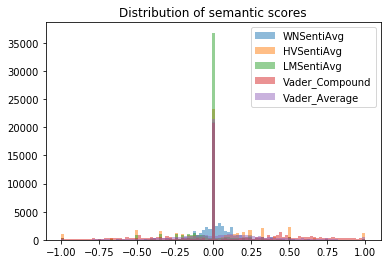

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

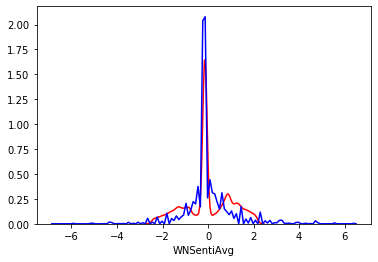

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,53675.000000,53675.000000,53675.000000,53675.000000,53675.000000
mean,0.027316,0.029766,-0.026680,0.060407,0.039514
std,0.152161,0.300635,0.160795,0.432794,0.266782
min,-1.000000,-1.000000,-1.000000,-0.999500,-1.000000
25%,0.000000,0.000000,0.000000,-0.051600,-0.010000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.062500,0.142857,0.000000,0.401900,0.133000
max,1.000000,1.000000,1.000000,0.999200,1.000000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [8]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [9]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'CommentID', 'CommentDate', 'CommenterURL',
       'CommentText', 'WNPositive', 'WNNegative', 'WNNeutral', 'WNSentiment',
       'WNTokenQnt', 'WNSentiAvg', 'HVPositive', 'HVNegative', 'HVTokenQnt',
       'HVSentiAvg', 'LMPositive', 'LMNegative', 'LMTokenQnt', 'LMSentiAvg',
       'Vader_Positive', 'Vader_Negative', 'Vader_Neutral', 'Vader_Compound',
       'Vader_Average', 'DateMonth', 'DateDay'],
      dtype='object')

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [11]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [12]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [13]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -10.6736
p-value                           0.0000
#Lags Used                       17.0000
Number of Observations Used    2139.0000
Critical Value (1%)              -3.4334
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -17.7646
p-value                           0.0000
#Lags Used                        4.0000
Number of Observations Used    2152.0000
Critical Value (1%)              -3.4334
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64


In [15]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -17.7646
p-value                           0.0000
#Lags Used                        4.0000
Number of Observations Used    2152.0000
Critical Value (1%)              -3.4334
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64
Results of Dickey-Fuller Test:


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -9.7816
p-value                           0.0000
#Lags Used                       20.0000
Number of Observations Used    2136.0000
Critical Value (1%)              -3.4334
Critical Value (5%)              -2.8629
Critical Value (10%)             -2.5675
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2011-06-23,0.000000,1,-0.6310,-0.165,0,1,8,0,1,8,0.000000,-0.125000,-0.125
2011-07-11,0.125000,1,0.6688,0.219,1,0,9,0,0,9,0.125000,0.111111,0.000
2011-07-27,-0.067308,1,0.2999,0.030,4,0,17,0,0,17,-0.067308,0.235294,0.000
2011-08-10,0.083333,1,0.6322,0.206,3,1,5,1,0,5,0.083333,0.400000,0.200
2011-08-11,-0.028409,1,0.6662,0.070,5,1,19,0,0,19,-0.028409,0.210526,0.000


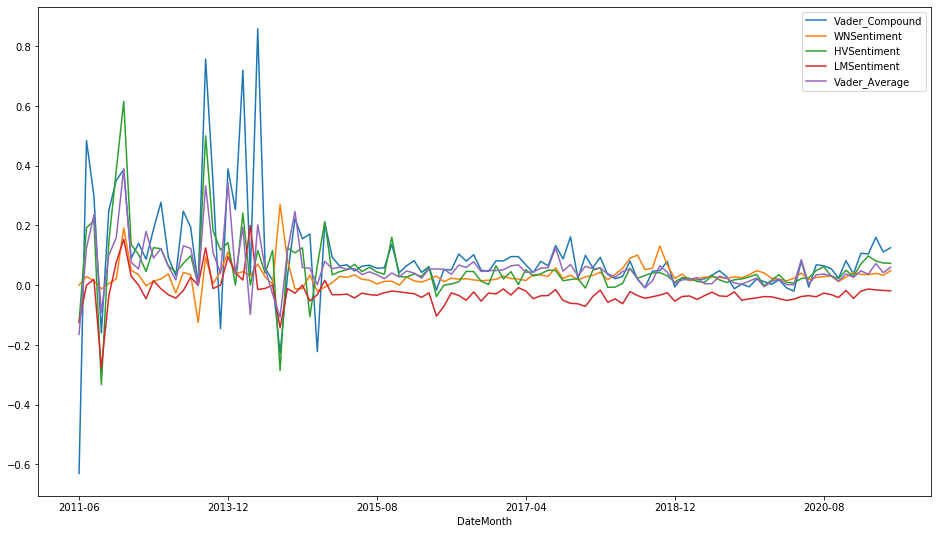

In [18]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [19]:
SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')

In [20]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [21]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [22]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [23]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [24]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [25]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [26]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [27]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2011-06,1345.199951,1258.069946,1345.199951,1320.640015,86122730000,1320.640015,-0.018426,0.000000,1,-0.631000,-0.165000,0,1,8,0,1,8,0.000000,-0.125000,-0.125000
2011-07,1356.479980,1282.859985,1320.640015,1292.280029,81102170000,1292.280029,-0.021708,0.057692,2,0.484350,0.124500,5,0,26,0,0,26,0.028846,0.192308,0.000000
2011-08,1307.380005,1101.540039,1292.589966,1218.890015,108419170000,1218.890015,-0.058468,0.102652,7,0.298771,0.235571,16,5,51,1,0,51,0.014665,0.215686,0.019608
2011-09,1229.290039,1114.219971,1219.119995,1131.420044,102786820000,1131.420044,-0.074467,-0.062500,5,-0.160040,-0.090800,0,6,18,0,5,18,-0.012500,-0.333333,-0.277778
2011-10,1292.660034,1074.770020,1131.209961,1253.300049,98063670000,1253.300049,0.102307,0.053971,10,0.251150,0.100300,21,9,83,3,6,83,0.005397,0.144578,-0.036145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,76.404470,2123,0.106775,0.047973,3653,2259,19638,603,999,19638,0.035989,0.070985,-0.020165
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,35.554546,1008,0.104644,0.036783,1739,846,9117,282,399,9117,0.035272,0.097949,-0.012833
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,50.886415,1283,0.160192,0.072603,2566,1455,13705,413,628,13705,0.039662,0.081065,-0.015688
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,31.388089,946,0.111396,0.041881,1853,1109,10004,321,498,10004,0.033180,0.074370,-0.017693


In [28]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 5


C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9888  , p=0.1587  , df_denom=1645, df_num=1
ssr based chi2 test:   chi2=1.9924  , p=0.1581  , df=1
likelihood ratio test: chi2=1.9912  , p=0.1582  , df=1
parameter F test:         F=1.9888  , p=0.1587  , df_denom=1645, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6867  , p=0.5034  , df_denom=1642, df_num=2
ssr based chi2 test:   chi2=1.3775  , p=0.5022  , df=2
likelihood ratio test: chi2=1.3770  , p=0.5023  , df=2
parameter F test:         F=0.6867  , p=0.5034  , df_denom=1642, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2441  , p=0.2922  , df_denom=1639, df_num=3
ssr based chi2 test:   chi2=3.7484  , p=0.2900  , df=3
likelihood ratio test: chi2=3.7441  , p=0.2905  , df=3
parameter F test:         F=1.2441  , p=0.2922  , df_denom=1639, df_num=3

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5044  , p=0.4777  , df_denom=1645, df_num=1
ssr based chi2 test:   chi2=0.5053  , p=0.4772  , df=1
likelihood ratio test: chi2=0.5052  , p=0.4772  , df=1
parameter F test:         F=0.5044  , p=0.4777  , df_denom=1645, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2989  , p=0.7417  , df_denom=1642, df_num=2
ssr based chi2 test:   chi2=0.5996  , p=0.7410  , df=2
likelihood ratio test: chi2=0.5995  , p=0.7410  , df=2
parameter F test:         F=0.2989  , p=0.7417  , df_denom=1642, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3600  , p=0.7819  , df_denom=1639, df_num=3
ssr based chi2 test:   chi2=1.0846  , p=0.7808  , df=3
likelihood ratio test: chi2=1.0842  , p=0.7809  , df=3
parameter F test:         F=0.3

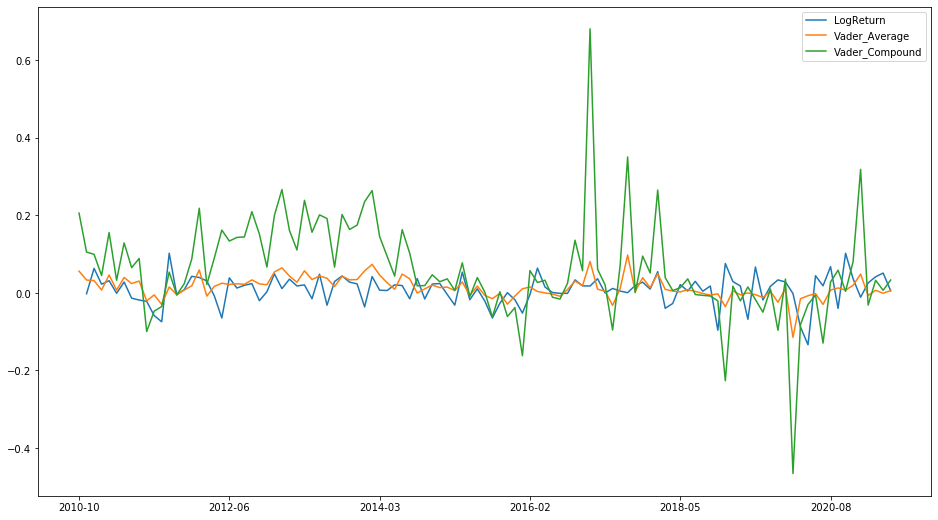

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [29]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.731673,0.284780,0.439655,0.385900,-0.003867
Vader_Average,0.731673,1.000000,0.383925,0.391551,0.375834,-0.025299
WNSentiment,0.284780,0.383925,1.000000,0.211554,0.249217,-0.016282
HVSentiment,0.439655,0.391551,0.211554,1.000000,0.453187,0.024354
LMSentiment,0.385900,0.375834,0.249217,0.453187,1.000000,-0.016175
LogReturn,-0.003867,-0.025299,-0.016282,0.024354,-0.016175,1.000000


In [30]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
corr_signif

,p-value
Vader_Compound,0.855307
Vader_Average,0.298402
WNSentiment,0.506949
HVSentiment,0.327821
LMSentiment,0.505560


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
